In [1]:
from subprocess import Popen, PIPE, CalledProcessError
import ast
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def simulate(mean_arrival_time, mean_departure_time, servers, simulation_time):
    cmd = '.\cmake-build-debug\mmc_simulation.exe {0} {1} {2} {3} --verbose'.format(mean_arrival_time, mean_departure_time, servers, simulation_time)
    with Popen(cmd, stdout=PIPE, stderr=PIPE, bufsize=1, universal_newlines=True) as p:
        cout, cerr = p.communicate()
        if p.returncode != 0:
            raise CalledProcessError(p.returncode, p.args)
        cout = cout.split('\n')
        cerr = cerr.split('\n')
        statistics = ast.literal_eval('{'+''.join(elem+',' for elem in cout[:4])[:-1]+'}')
        if 'stationary probabilities for states' in cout[-2]:
            last_index = -2
        else:
            last_index = -1
        probabilities = ast.literal_eval('{'+''.join(elem+',' for elem in cout[5:last_index])[:-1]+'}')
        events = []
        for sample in cerr[1:-1]:
            time = sample[:sample.find(':')]
            sample = sample[len(time)+2:]
            what_happened = sample[:sample.find(',')]
            sample = sample[len(what_happened)+2:]
            what_happened = what_happened.split(' ')
            active_servers = sample[sample.find('- ')+2:sample.find('/')]
            event = dict([('time', float(time)), ('event', what_happened), ('active_servers', int(active_servers))])
            events.append(event)
        return statistics, probabilities, events

In [3]:
def experiment(mean_arrival_time, mean_departure_time, servers, simulation_time):
    statistics, probabilities, events = simulate(mean_arrival_time, mean_departure_time, servers, simulation_time)
    time = [event['time'] for event in events]
    active = [event['active_servers'] for event in events]
    plt.figure(figsize=(20,5))
    plt.plot(time, active)
    plt.axis([min(time), max(time), 0, servers+1])
    plt.show()
    for statistic in statistics:
        print(statistic, statistics[statistic])
    print('')
    print('Stationary probabilities:')
    format_string = '{:'+str(len(str(len(probabilities))))+'d}:'
    for state in probabilities:
        print(format_string.format(state), probabilities[state])
    num_arrivals = len([event for event in events if event['event'][0] == 'arrival'])
    print('Средняя вероятность отказа -', np.round(statistics['denied']/num_arrivals, 3))

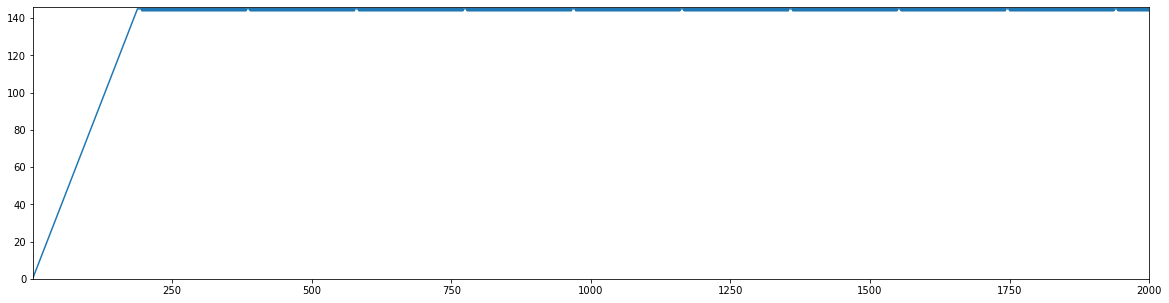

total_time 2000.0
served 1349
denied 50
average_state 141

Stationary probabilities:
  0: 0.000346
  1: 0.000346
  2: 0.000346
  3: 0.000346
  4: 0.000346
  5: 0.000346
  6: 0.000346
  7: 0.000346
  8: 0.000346
  9: 0.000346
 10: 0.000346
 11: 0.000346
 12: 0.000346
 13: 0.000346
 14: 0.000346
 15: 0.000346
 16: 0.000346
 17: 0.000346
 18: 0.000346
 19: 0.000346
 20: 0.000346
 21: 0.000346
 22: 0.000346
 23: 0.000346
 24: 0.000346
 25: 0.000346
 26: 0.000346
 27: 0.000346
 28: 0.000346
 29: 0.000346
 30: 0.000346
 31: 0.000346
 32: 0.000346
 33: 0.000346
 34: 0.000346
 35: 0.000346
 36: 0.000346
 37: 0.000346
 38: 0.000346
 39: 0.000346
 40: 0.000346
 41: 0.000346
 42: 0.000346
 43: 0.000346
 44: 0.000346
 45: 0.000346
 46: 0.000346
 47: 0.000346
 48: 0.000346
 49: 0.000346
 50: 0.000346
 51: 0.000346
 52: 0.000346
 53: 0.000346
 54: 0.000346
 55: 0.000346
 56: 0.000346
 57: 0.000346
 58: 0.000346
 59: 0.000346
 60: 0.000346
 61: 0.000346
 62: 0.000346
 63: 0.000346
 64: 0.000346
 65: 

In [4]:
mean_arrival_time = 1
mean_departure_time = 150
servers = 145
simulation_time = 2000
experiment(mean_arrival_time, mean_departure_time, servers, simulation_time)

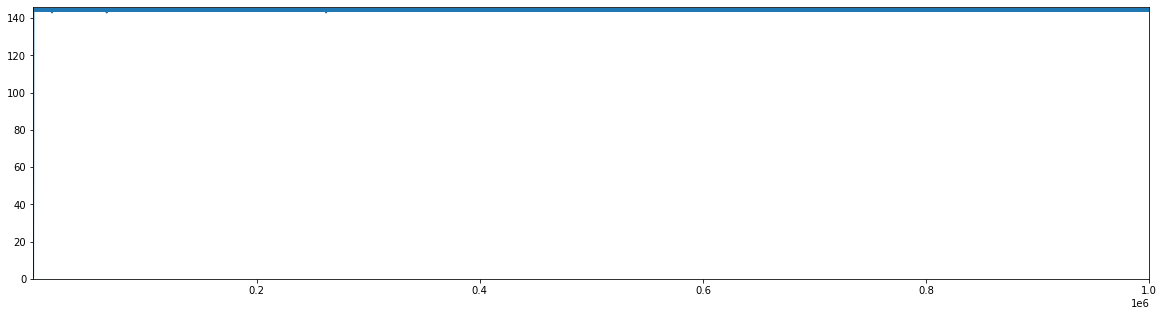

total_time 1000000.0
served 745156
denied 26580
average_state 145

Stationary probabilities:
  0: 6.59e-07
  1: 6.59e-07
  2: 6.59e-07
  3: 6.59e-07
  4: 6.59e-07
  5: 6.59e-07
  6: 6.59e-07
  7: 6.59e-07
  8: 6.59e-07
  9: 6.59e-07
 10: 6.59e-07
 11: 6.59e-07
 12: 6.59e-07
 13: 6.59e-07
 14: 6.59e-07
 15: 6.59e-07
 16: 6.59e-07
 17: 6.59e-07
 18: 6.59e-07
 19: 6.59e-07
 20: 6.59e-07
 21: 6.59e-07
 22: 6.59e-07
 23: 6.59e-07
 24: 6.59e-07
 25: 6.59e-07
 26: 6.59e-07
 27: 6.59e-07
 28: 6.59e-07
 29: 6.59e-07
 30: 6.59e-07
 31: 6.59e-07
 32: 6.59e-07
 33: 6.59e-07
 34: 6.59e-07
 35: 6.59e-07
 36: 6.59e-07
 37: 6.59e-07
 38: 6.59e-07
 39: 6.59e-07
 40: 6.59e-07
 41: 6.59e-07
 42: 6.59e-07
 43: 6.59e-07
 44: 6.59e-07
 45: 6.59e-07
 46: 6.59e-07
 47: 6.59e-07
 48: 6.59e-07
 49: 6.59e-07
 50: 6.59e-07
 51: 6.59e-07
 52: 6.59e-07
 53: 6.59e-07
 54: 6.59e-07
 55: 6.59e-07
 56: 6.59e-07
 57: 6.59e-07
 58: 6.59e-07
 59: 6.59e-07
 60: 6.59e-07
 61: 6.59e-07
 62: 6.59e-07
 63: 6.59e-07
 64: 6.59e-

In [5]:
mean_arrival_time = 1
mean_departure_time = 150
servers = 145
simulation_time = 1000000
experiment(mean_arrival_time, mean_departure_time, servers, simulation_time)